#### Loading in the data

In [39]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf
import plotly.graph_objects as go
from prophet import Prophet
from colorama import Fore
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [40]:
ticker = 'GC=F'  # Gold Futures ticker on Yahoo Finance
gold = yf.download(ticker, start='2016-01-01', end='2025-01-01', interval='1d')
gold.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [41]:
gold.to_csv('gold_prices_2016_2025.csv')

#### Checking the data


Removing the "ticker" row

In [42]:
gold.columns = gold.columns.droplevel(1)
gold.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2016-01-04,1075.099976,1082.500000,1063.199951,1063.400024,143
2016-01-05,1078.400024,1081.500000,1075.300049,1075.599976,82
2016-01-06,1091.900024,1093.699951,1081.599976,1081.599976,52
2016-01-07,1107.699951,1109.400024,1091.599976,1091.599976,122
2016-01-08,1097.800049,1111.099976,1093.000000,1111.099976,98


In [43]:
gold.describe()

Price,Close,High,Low,Open,Volume
count,2261.000000,2261.000000,2261.000000,2261.000000,2261.000000
mean,1652.980317,1660.537551,1645.281999,1652.768554,5274.795223
std,383.260426,385.458997,380.943530,383.159313,29509.349030
min,1073.900024,1081.500000,1063.199951,1063.400024,0.000000
25%,1288.400024,1292.000000,1283.599976,1287.300049,47.000000
50%,1705.000000,1715.300049,1694.699951,1704.699951,181.000000
75%,1898.599976,1907.699951,1886.099976,1897.300049,560.000000
max,2788.500000,2789.000000,2774.600098,2787.399902,386334.000000


In [44]:
gold.dtypes

Price
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Checking for missing values

In [45]:
gold.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

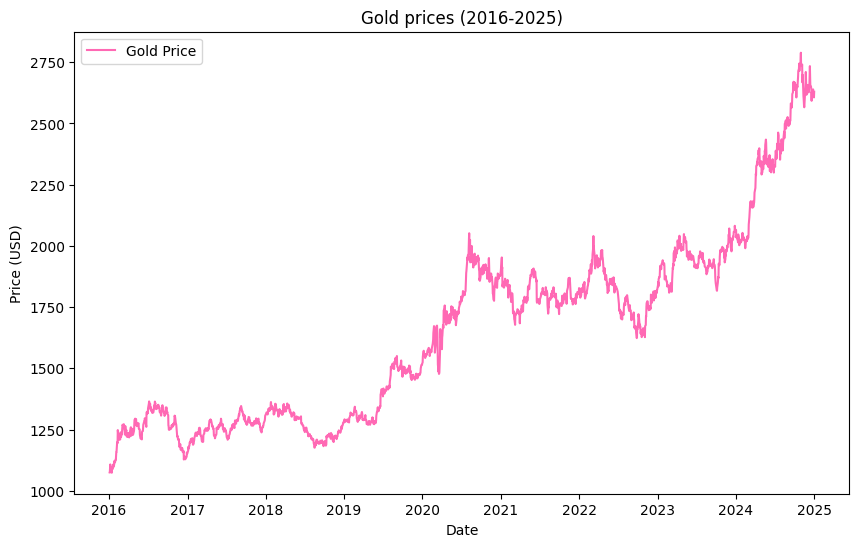

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(gold['Close'], label='Gold Price', color='hotpink')
plt.title('Gold prices (2016-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Checking outliers

In [47]:
gold['z_score'] = zscore(gold['Close'])
outliers = gold[gold['z_score'].abs() > 3]
print("Outliers detected:", outliers)

Outliers detected: Empty DataFrame
Columns: [Close, High, Low, Open, Volume, z_score]
Index: []


In [50]:
gold = gold[['Close']]
gold.head()

Price,Close
Date,
2016-01-04,1075.099976
2016-01-05,1078.400024
2016-01-06,1091.900024
2016-01-07,1107.699951
2016-01-08,1097.800049


#### Checking stationarity

In [51]:
adf_test = adfuller(gold['Close'])
print("ADF statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical values:", adf_test[4])

if adf_test[1] < 0.05:
    print("Reject the null hypothesis - series is stationary")
else:
    print("Fail to reject the null hypothesis - series is non-stationary")

ADF statistic: 0.12059219759182055
p-value: 0.9674392205479142
Critical values: {'1%': np.float64(-3.433248072725654), '5%': np.float64(-2.8628202931061955), '10%': np.float64(-2.567451559747925)}
Fail to reject the null hypothesis - series is non-stationary


In [52]:
gold['Close_Diff'] = gold['Close'].diff()
gold['Close_Log'] = np.log(gold['Close'])
gold['Close_Log_Diff'] = gold['Close_Log'].diff()

# Drop NaN values caused by differencing
gold.dropna(subset=['Close_Diff', 'Close_Log', 'Close_Log_Diff'], inplace=True)

In [53]:
series_list = {
    'Close_Diff': gold['Close_Diff'],
    'Close_Log': gold['Close_Log'],
    'Close_Log_Diff': gold['Close_Log_Diff']
}

for label, series in series_list.items():
    adf_test = adfuller(series)
    adf_p_value = adf_test[1]
    if adf_p_value < 0.05:
        print(f"{label} is stationary, with p-value: {adf_p_value}")
    else:
        print(f"{label} is non-stationary, with p-value: {adf_p_value}")

Close_Diff is stationary, with p-value: 0.0
Close_Log is non-stationary, with p-value: 0.9029816332621483
Close_Log_Diff is stationary, with p-value: 0.0


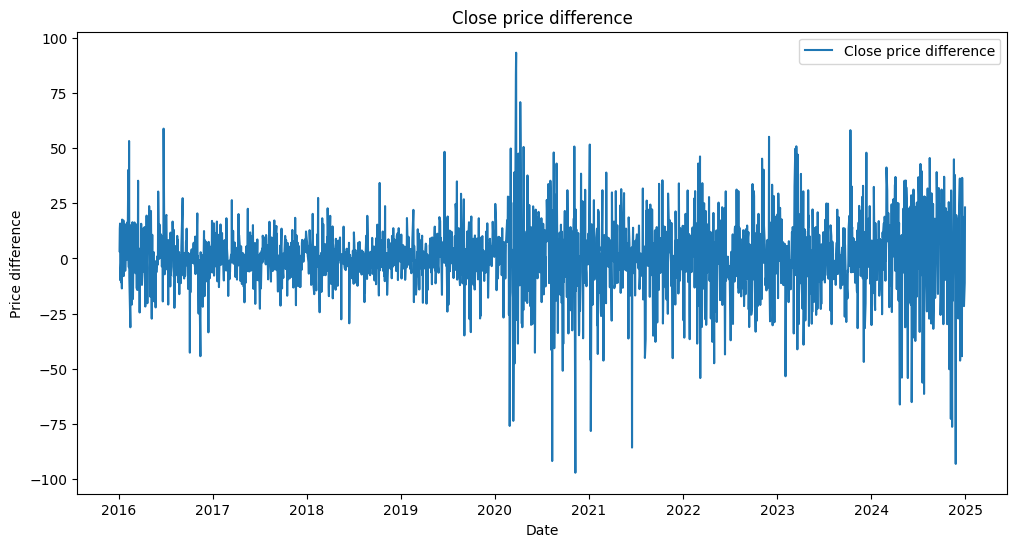

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Diff'], label='Close price difference')
plt.title('Close price difference')
plt.xlabel('Date')
plt.ylabel('Price difference')
plt.legend()
plt.show()

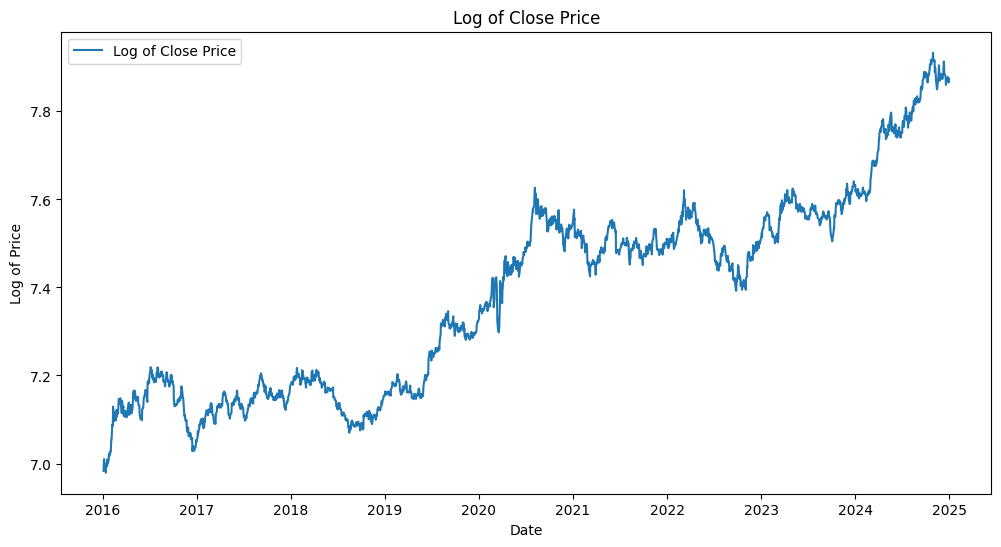

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Log'], label='Log of Close Price')
plt.title('Log of Close Price')
plt.xlabel('Date')
plt.ylabel('Log of Price')
plt.legend()
plt.show()

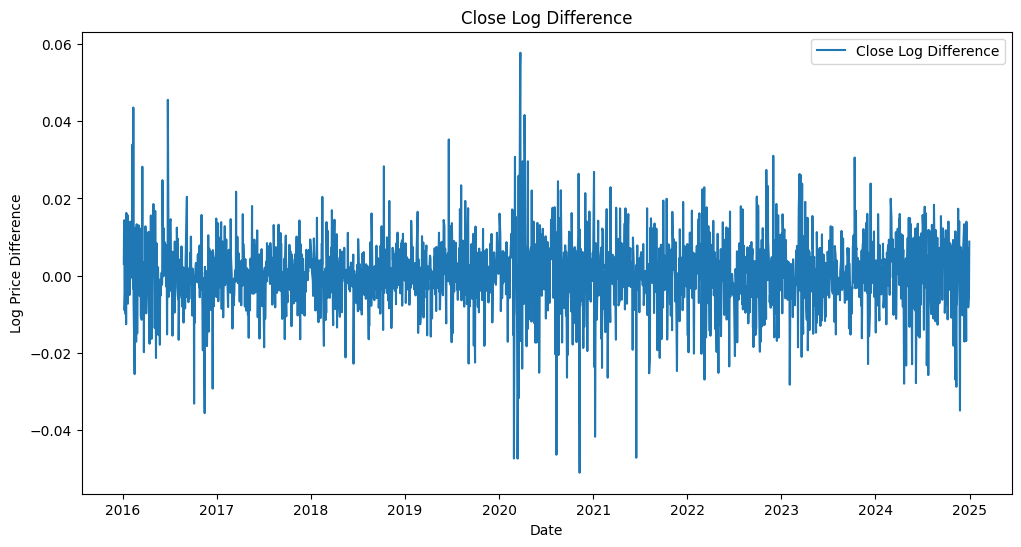

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(gold['Close_Log_Diff'], label='Close Log Difference')
plt.title('Close Log Difference')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')
plt.legend()
plt.show()

In [57]:
gold.head()

Price,Close,Close_Diff,Close_Log,Close_Log_Diff
Date,,,,
2016-01-05,1078.400024,3.300049,6.983234,0.003065
2016-01-06,1091.900024,13.500000,6.995675,0.012441
2016-01-07,1107.699951,15.799927,7.010041,0.014366
2016-01-08,1097.800049,-9.899902,7.001064,-0.008978
2016-01-11,1096.500000,-1.300049,6.999879,-0.001185


#### Moving Average

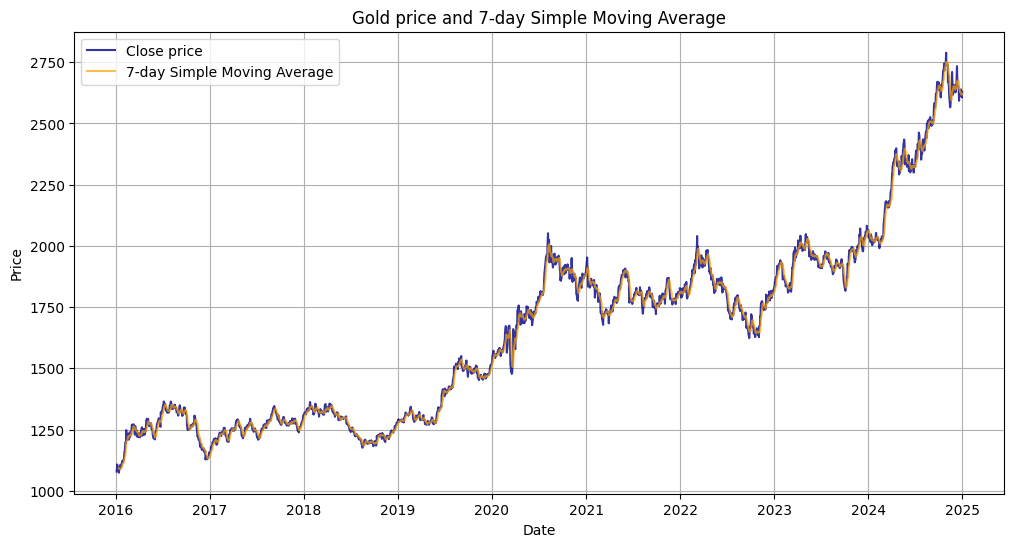

In [60]:
gold['SMA_7'] = gold['Close'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(gold['Close'], label='Close price', color='darkblue', alpha=0.8)
plt.plot(gold['SMA_7'], label='7-day Simple Moving Average', color='orange', alpha=0.7)
plt.title('Gold price and 7-day Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


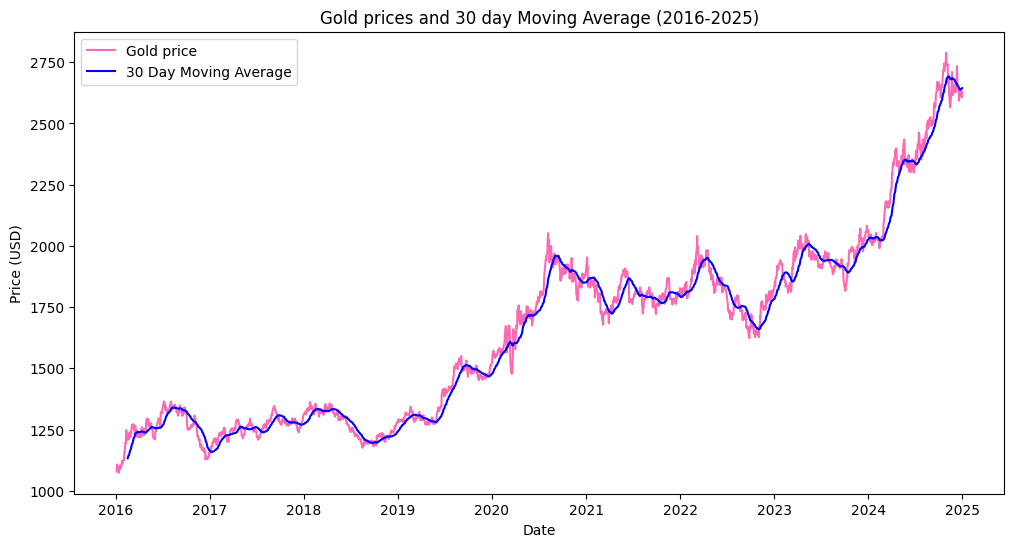

In [61]:
gold['30_day_MA'] = gold['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(gold['Close'], label='Gold price', color='hotpink')
plt.plot(gold['30_day_MA'], label='30 Day Moving Average', color='blue')
plt.title('Gold prices and 30 day Moving Average (2016-2025)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

#### Decomposition

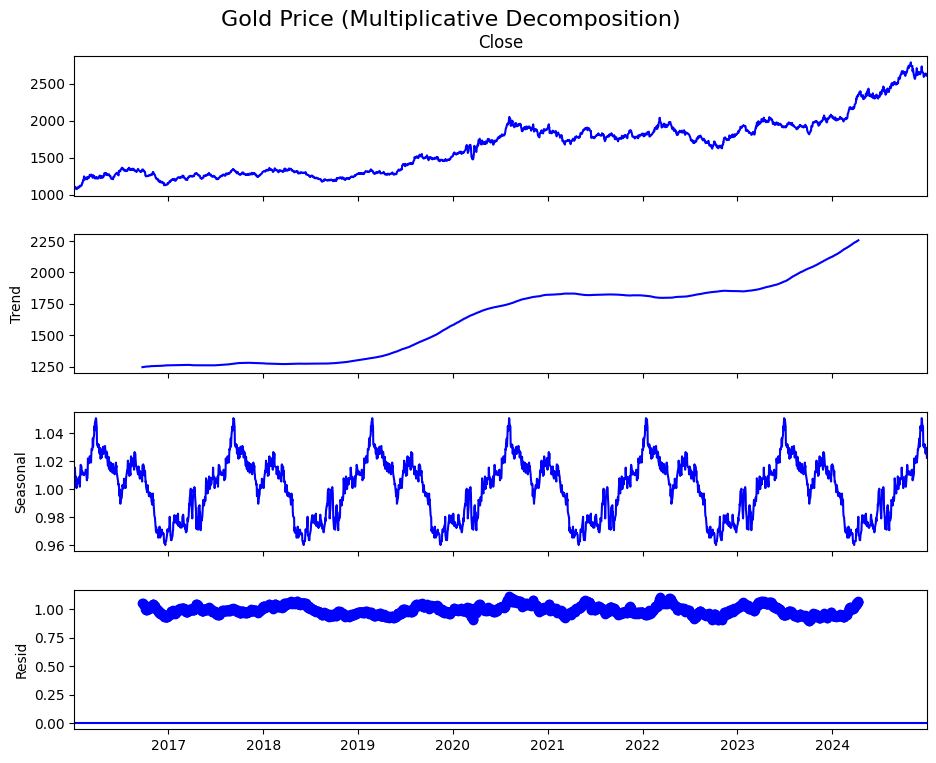

In [62]:
def plot_decomposition(series, model, period, title, plot_color):
    decomposition = seasonal_decompose(series, model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.suptitle(title, fontsize=16)
    for ax in fig.axes:
        for line in ax.get_lines():
            line.set_color(plot_color)
    plt.show()

plot_decomposition(gold['Close'], model='multiplicative', period=365, title="Gold Price (Multiplicative Decomposition)", plot_color='blue')